<a href="https://colab.research.google.com/github/Headtrick/DataScience_and_MachineLearning/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip 'drive/MyDrive/Dog Vision/dog-breed-identification.zip' -d 'drive/MyDrive/Dog Vision/'

# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-clss image classifier using TensorFlow 2.11 and Tensor Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation


The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/data

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer lerning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

### Get our workspace ready

* Import TensorFLow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [40]:
# Import TensorFlow into Colab
# import tensorflow as tf
# print('TF version:', tf.__version__)

In [41]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Check for GPU availability
print("GPU", 'available (Yes!!!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

TF version: 2.11.0
TF Hub version: 0.12.0
GPU available (Yes!!!!)


## Getting our data ready (turning it into Tensors)

with all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [42]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv('drive/MyDrive/Dog Vision/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [43]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


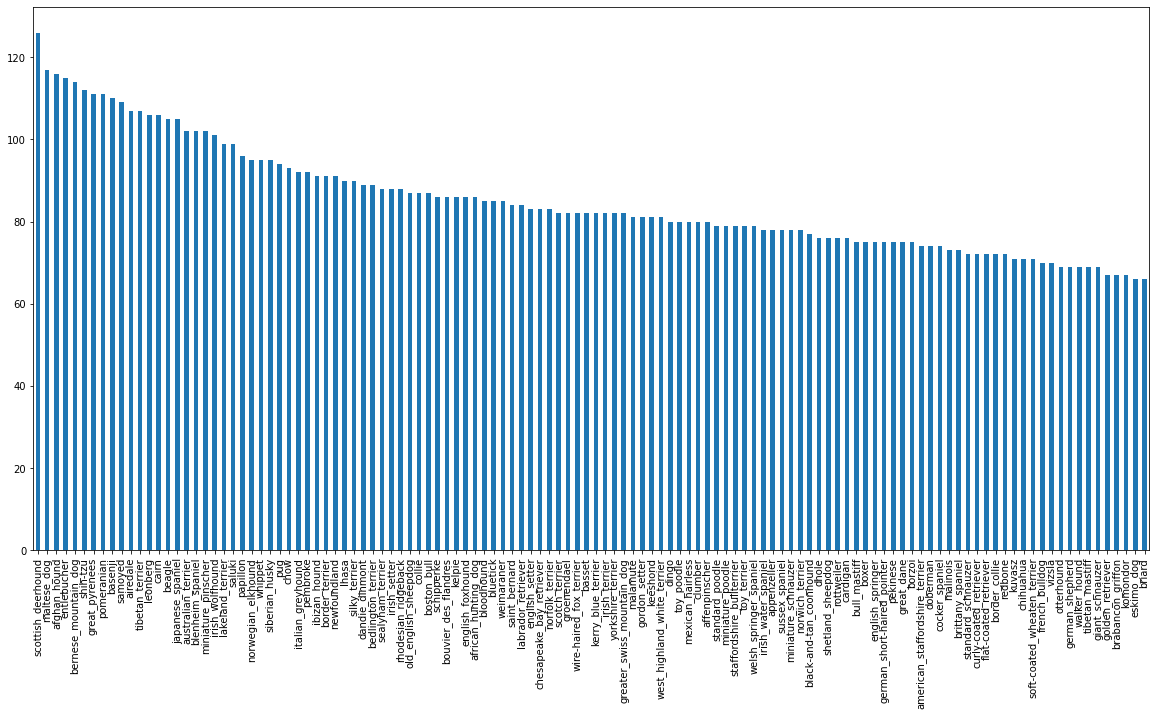

In [44]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [45]:
labels_csv['breed'].value_counts().median()

82.0

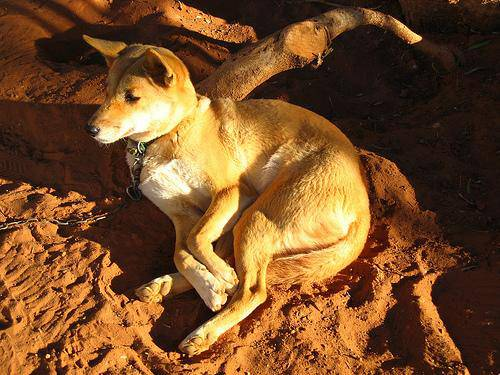

In [46]:
# Let's view an image
from IPython.display import Image
Image('drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all of our images pathnames.

In [47]:
# Create pathnames from image ID's
filenames = ['drive/My Drive/Dog Vision/train/'+ fname +'.jpg' for fname in labels_csv['id']]

# Check the first 10
filenames[:10]
len(filenames)

10222

In [48]:
import os
os.listdir('drive/My Drive/Dog Vision/train/')[:10]

['e08c321bfa4141ecfc3dc6c5488ec770.jpg',
 'df464ebe3f311744241cb3d9258a5000.jpg',
 'e8f5dd1ad67209c064965691030a07e5.jpg',
 'dd82e748363c70f532e630c5197dd789.jpg',
 'dc99929daa2c14970c44afaf16ff502f.jpg',
 'e6e89b7a7579de5c5ced94253491953e.jpg',
 'e614058019fbb49489ee4f9090cf25ef.jpg',
 'e073b458a33cbfe9b733764a1246f52e.jpg',
 'e7c5692d044250d303a839d989132bf1.jpg',
 'e7f4f3c25291884f2dfe7c60051d6949.jpg']

In [49]:
# Check whether number of filenames matches number of actial image files
import os 
if len(os.listdir('drive/My Drive/Dog Vision/train/')) == len(filenames):
  print('Filenames match actual amount of files!!! Proceed.')
else:
    print('Filenames do not match actual amount of files, check the target directory.')

Filenames match actual amount of files!!! Proceed.


In [50]:
len(os.listdir('drive/My Drive/Dog Vision/train/'))

10222

In [51]:
len(filenames)

10222

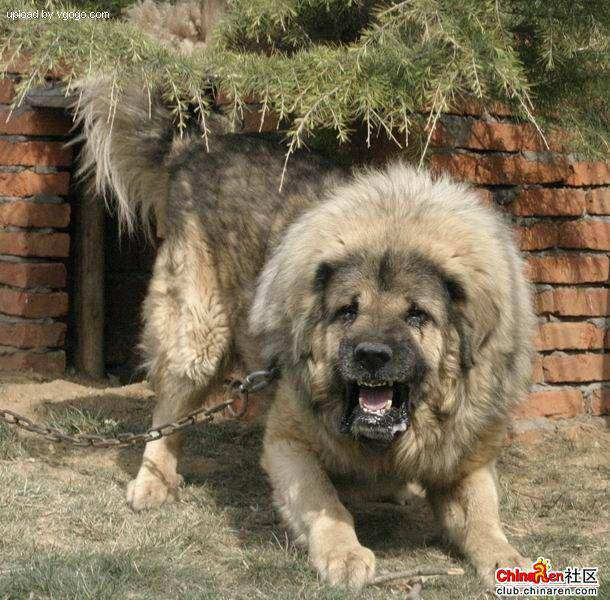

In [52]:
Image(filenames[9000])

In [53]:
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [54]:
import numpy as np
labels = labels_csv['breed'] #labels = labels_csv['breed'].to_numpy() will do same thing a below cell
labels = np.array(labels)
labels


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [55]:
len(labels)

10222

In [56]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames!')
else:
  print('Number of labels does not match number of filenames, check data directories')

Number of labels matches number of filenames!


In [57]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [58]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [59]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [60]:
len(boolean_labels)

10222

In [61]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [62]:
print(boolean_labels[0].astype(int))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validatino set
Since the dataset from Kaggle doesn't come with validation set, we're going to create our own.

In [63]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [64]:
len(X)

10222

In [65]:
len(y)

10222

We're going to start off experimenting with around 1000 images and increase as needed.

In [66]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {type:'slider', min:1000, max:10000, step:1000}

In [67]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [68]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

## Preprocessing Images (turning images into Tensors)

To preprocees our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn `image` (a jpg) into Tensors
4. Normalize our `image`(convert color chaneel values from 0-255 to 0-1).
5. Resize the `image` to be shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like

In [69]:
# Convern image to NumPy
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [70]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [71]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  '''
  Takes an image file path and turns the image into a Tensor
  '''

  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour chaneels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value(224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go.. they all might not fit into memory.

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust the batch size if need be).

In orget to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [72]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  '''
  image = process_image(image_path)

  return image, label

In [78]:
# Demo of the above
process_image(X[42]), tf.constant(y[42].astype(int))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors
in the form: `(image. label)`, let's make a function to turn all of our data(X & y) into batches!

In [116]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Creates batches of data our of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also, accepts test data as input(no labels).
  '''

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (nolabels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                          tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                          tf.constant(y))) # labels 
    # Shuffling pathnames and labels before maping image processor function is fasted than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a proproceed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch


In [117]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [118]:
# Check out the different attributres of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [111]:
val_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [109]:
y_train[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## VIsualizing Data Batches
Our data is now in batches, however, these can be little hard to understand/comprehend, let's visualize them

In [131]:
import matplotlib.pyplot as plt

# Crate a function for viewing images in a data batch
def show_25_images(image, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure 
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range (25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5, i+1)
    # Display and image
    plt.imshow(image[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [128]:
train_images, train_labels = next(train_data.as_numpy_iterator())


In [129]:
len(train_images), len(train_labels)

(32, 32)

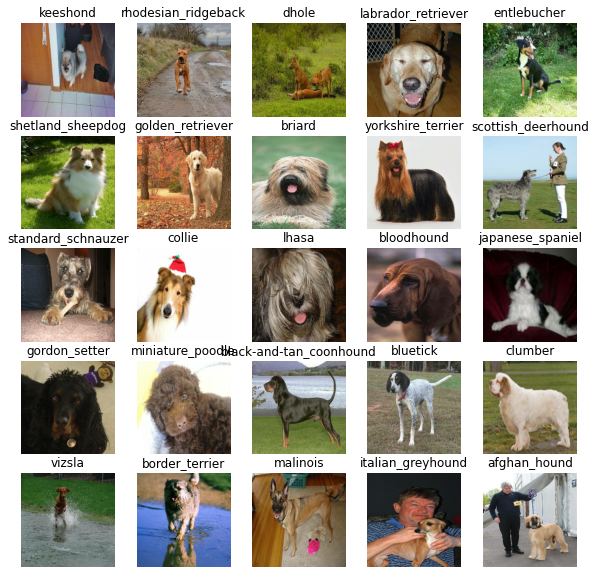

In [132]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

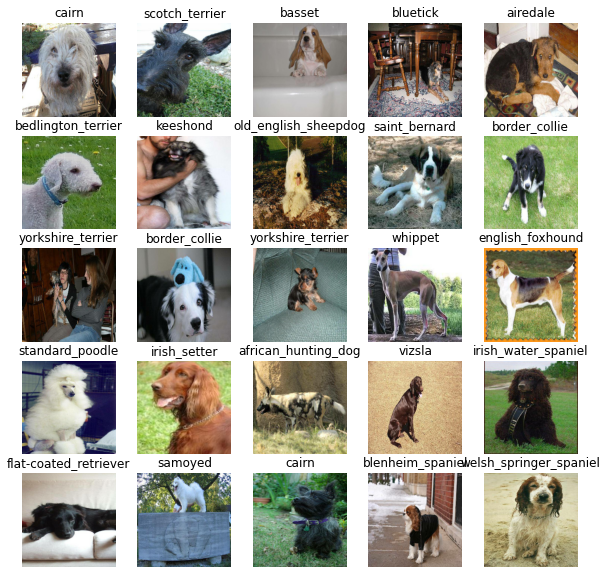

In [133]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)